In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from scipy.optimize import curve_fit
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from models import *

## Load data to fit "ground truth" curves

In [2]:
bat_dict = pickle.load(open(r'../Data/bat_dict_small.pkl', 'rb'))

In [3]:
def func(x, a, b, c):
    #return np.exp(a/temps)*x**b + c
    return np.exp(a)*x**b + c

In [4]:
params = []
cycle_lives = []
for id in bat_dict.keys():
    bat = bat_dict[id]
    #temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
    Y = 1-bat['summary']['QD'][1:]/1.1
    length = len(bat['summary']['QD'][1:])
    x = np.arange(1,length+1)
    param = curve_fit(func, x, Y, maxfev = 4000)[0]

    alpha = param[0]
    beta = param[1]
    gamma = param[2]
    params.append([alpha,beta,gamma])
    
    cycle_lives.append(bat["cycle_life"][0])
params = np.array(params)
cycle_lives = np.array(cycle_lives)

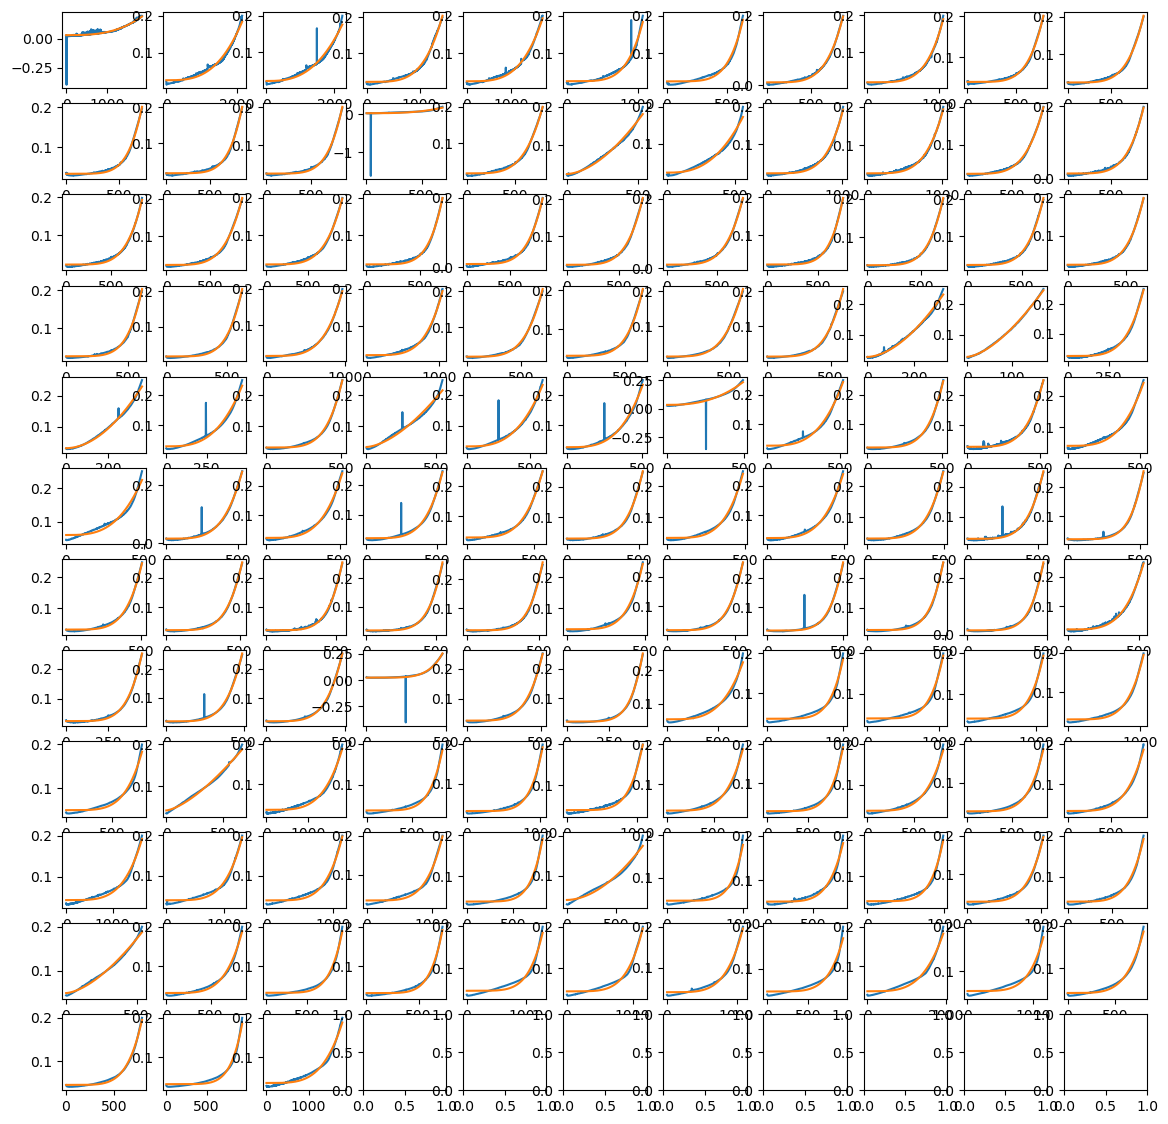

In [5]:
# visualize curve fits
fig,axs=plt.subplots(nrows=12,ncols=11,figsize=(14,14))
for ix,id in enumerate(bat_dict.keys()):
    ax = axs[int(ix/11)][ix%11]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y)

    alpha = params[ix][0]
    beta = params[ix][1]
    gamma = params[ix][2]
    ax.plot(x, func(x,alpha,beta,gamma), linestyle="-")

/tmp/ipykernel_250825/1597675415.py:14: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(x[5:-5]), np.log(dY2))
/tmp/ipykernel_250825/1597675415.py:16: RuntimeWarning: divide by zero encountered in log
  mask = np.logical_not(np.isinf(np.log(dY2)))
/tmp/ipykernel_250825/1597675415.py:17: RuntimeWarning: divide by zero encountered in log
  poly = np.polyfit(np.log(x[5:-5])[mask], np.log(dY2)[mask], 1)


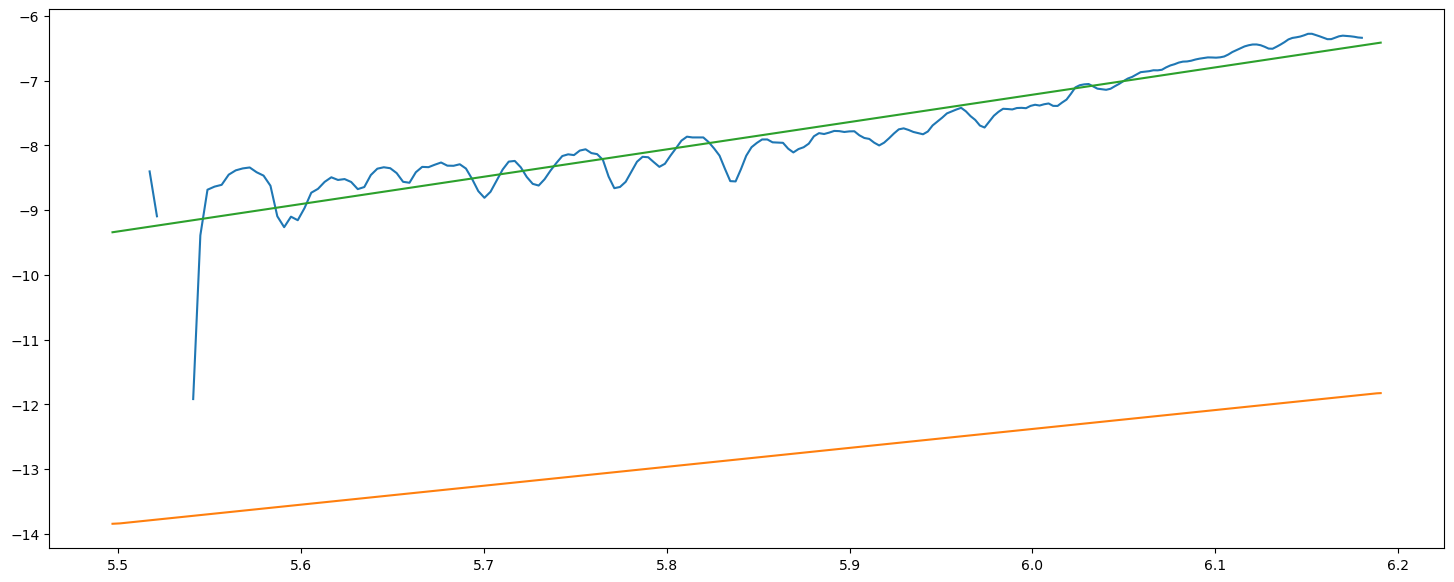

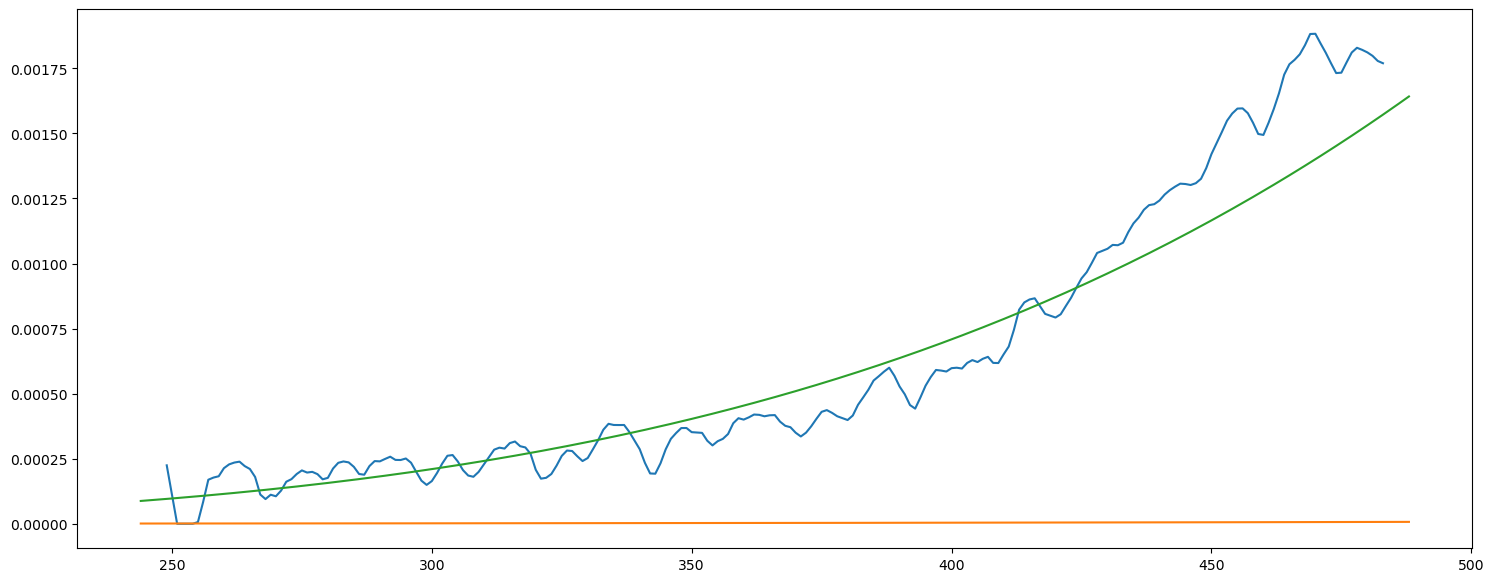

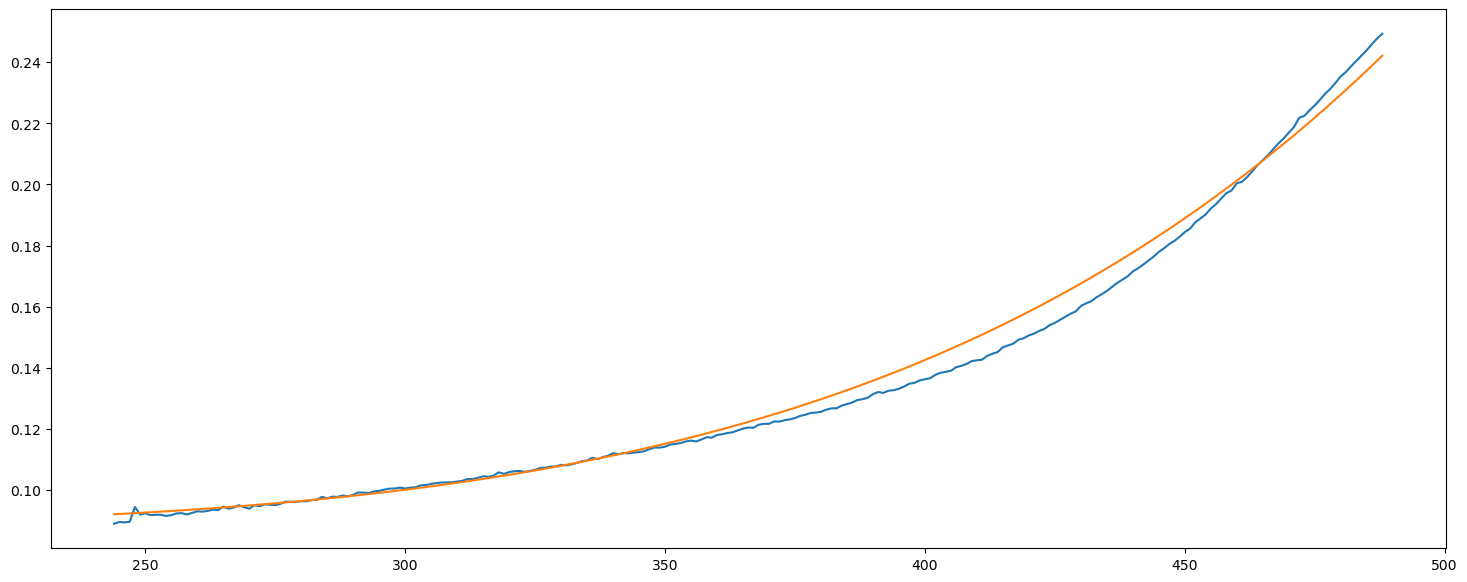

In [188]:
for ix,id in enumerate(bat_dict.keys()):
    if ix == 55:
        length = len(bat_dict[id]['summary']['QD'])
        x = np.arange(length//2,length)
        Y = 1-bat_dict[id]['summary']['QD'][length//2:length]/1.1

        Y2 = np.convolve(Y, np.array([1, 2, 4, 8, 4, 2, 1])/22, mode = "same")
        Y2 = np.convolve(Y2, np.array([1, 1, 1, 1, 1])/5, mode = "same")[5:-5]
        for i, y in enumerate(Y2[1:]):
            if y <= Y2[i]: Y2[i+1] = Y2[i]

        dY2 = np.gradient(Y2)

        plt.plot(np.log(x[5:-5]), np.log(dY2))
        plt.plot(np.log(x), np.log(np.gradient(func(x,alpha,beta,gamma))))
        mask = np.logical_not(np.isinf(np.log(dY2)))
        poly = np.polyfit(np.log(x[5:-5])[mask], np.log(dY2)[mask], 1)
        fit = poly[0]*np.log(x) + poly[1]
        plt.plot(np.log(x), fit)
        plt.show()
        
        plt.plot(x[5:-5], dY2)
        plt.plot(x, np.gradient(func(x,alpha,beta,gamma)))
        plt.plot(x, np.exp(fit))
        plt.show()

        plt.plot(x, Y)
        curve = np.cumsum(np.exp(fit))
        const = np.mean(np.abs(curve[:100] - Y[:100]))
        plt.plot(x, curve+const)
        plt.show()


In [194]:
params_grad = []
cycle_lives = []
for id in bat_dict.keys():
    length = len(bat_dict[id]['summary']['QD'])
    x = np.arange(length//2,length)
    Y = 1-bat_dict[id]['summary']['QD'][length//2:length]/1.1

    Y2 = np.convolve(Y, np.array([1, 2, 4, 8, 4, 2, 1])/22, mode = "same")
    Y2 = np.convolve(Y2, np.array([1, 1, 1, 1, 1])/5, mode = "same")[5:-5]
    for i, y in enumerate(Y2[1:]):
        if y <= Y2[i]: Y2[i+1] = Y2[i]
    dY2 = np.gradient(Y2)

    mask = np.logical_not(np.isinf(np.log(dY2)))
    poly = np.polyfit(np.log(x[5:-5])[mask], np.log(dY2)[mask], 1)
    fit = poly[0]*np.log(x) + poly[1]
    curve = np.cumsum(np.exp(fit))
    const = np.mean(np.abs(curve[:100] - Y[:100]))

    params_grad.append([poly[0], poly[1], const])
    cycle_lives.append(bat["cycle_life"][0])

params_grad = np.array(params_grad)
cycle_lives = np.array(cycle_lives)

/tmp/ipykernel_250825/177779164.py:14: RuntimeWarning: divide by zero encountered in log
  mask = np.logical_not(np.isinf(np.log(dY2)))
/tmp/ipykernel_250825/177779164.py:15: RuntimeWarning: divide by zero encountered in log
  poly = np.polyfit(np.log(x[5:-5])[mask], np.log(dY2)[mask], 1)


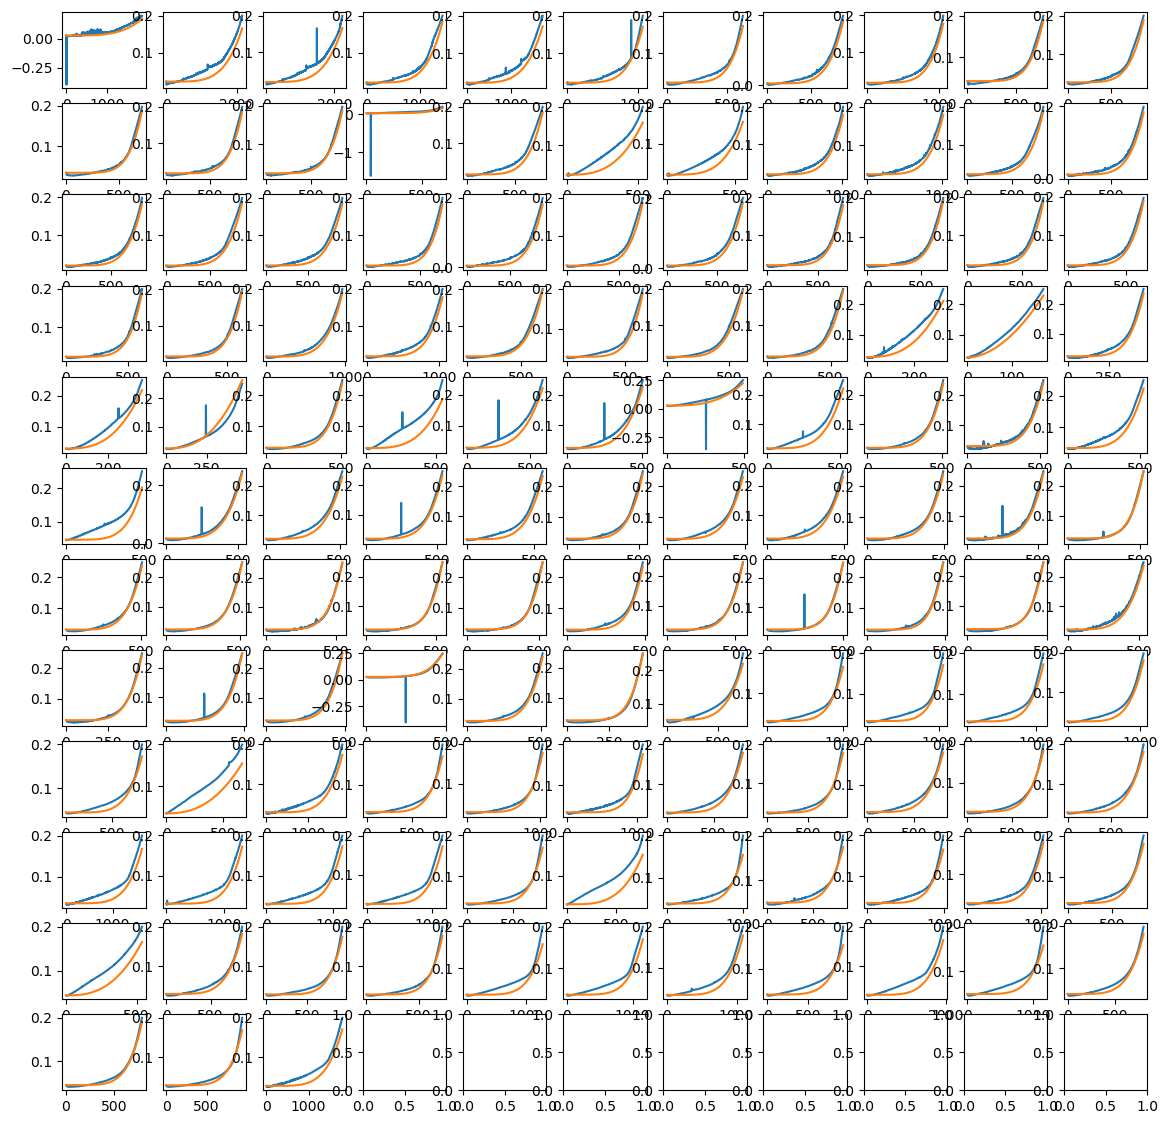

In [195]:
# visualize curve fits
fig,axs=plt.subplots(nrows=12,ncols=11,figsize=(14,14))
for ix,id in enumerate(bat_dict.keys()):
    ax = axs[int(ix/11)][ix%11]
    length = len(bat_dict[id]['summary']['QD'])
    # x = np.arange(length//2,length)
    # Y = 1-bat_dict[id]['summary']['QD'][length//2:length]/1.1
    x = np.arange(1, length)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y)
    slope = params_grad[ix][0]
    intercept = params_grad[ix][1]
    const = params_grad[ix][2]
    ax.plot(x, np.cumsum(np.exp(slope*np.log(x)+intercept))+const)
plt.show()

## Load data for predictive model

In [196]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123])

In [197]:
data = pickle.load(open(r'../Data/sev_deltaQ_cycles.pkl', 'rb'))
n_cycles = 98
cut_start = 0

features = [
    "DeltaQ_logVars",
    "DeltaQ_mins",
    # "DeltaQ_means",
    # "DeltaT_max",
    "DeltaT_logVars",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:n_cycles]
    y[i] = data[cell]["cycle_life"]

train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(params_grad[train_ind]), torch.tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x[test_ind]),torch.Tensor(params_grad[test_ind]), torch.tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x[secondary_ind]),torch.Tensor(params_grad[secondary_ind]), torch.tensor(y[secondary_ind]))

In [180]:
from models import AutoEncoder_ElasticNet

class AttentionModel2(torch.nn.Module):
    def __init__(self, d_model, feat_dim, n_cycle, vdim=1, num_heads=1, attn_model="softmax", beta=1, skip_connect=0):
        super(AttentionModel2, self).__init__()
        '''d_model: embedding dimension; can be chosen independently of input data dimensions
           feat_dim: number of features in a cycle
           n_cycle: number of "cycles" outputted by the encoder / number of tokens, each of which has feat_dim features
           vdim: dimension of output, 1 for our regression problem
           num_heads: default 1
           attn_model: default softmax; code also supports batch normalized attention with keyword "batch_norm"
           beta: if using batch normalized attention, beta is the weight placed on the mean
           skip_connect: whether or not to add a skip connection. If 0, no skip connection. If 1, H=AV+B where B
           is a trainable projection of the input X. If 2, H=AV+V'''
        assert d_model % num_heads == 0, "Embedding dimension (d_model) must be divisible by number of attention heads (num_heads)."
        
        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim*num_heads)
        self.W_b = nn.Linear(feat_dim, vdim*num_heads)
        self.W_o = nn.Linear(vdim*num_heads, vdim)

        self.create_output = nn.Linear(n_cycle,1) # final linear layer to collapse output

        self.d_model = d_model
        self.vdim = vdim
        self.num_heads = num_heads
        #self.head_dim = d_model // num_heads
        
        self.attn_model = attn_model
        self.beta = beta
        self.skip_connect = skip_connect

    def split_heads(self, M):
        batch_size, n_cycle, embed_dim = M.size()
        head_dim = embed_dim // self.num_heads
        M = M.view(batch_size, n_cycle, self.num_heads, head_dim).transpose(1,2)
        return M

    def scaled_dot_product_attention(self, Q, K, V, B): 
        '''softmax attention'''
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model // self.num_heads)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, n_cycle, n_cycle)
        output = torch.matmul(attn_probs, V) # dimensionality (batch size, n_cycle, 1)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def batch_normalized_attention(self, Q, K, V, B):
        '''batch normalized attention'''
        mu = torch.mean(K,0)
        s = torch.std(K,0,correction=0)
        attn_scores = torch.matmul(torch.mul(Q-self.beta*mu,s), torch.mul(K-self.beta*mu,s).transpose(-2,-1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, batch size)
        output = torch.matmul(attn_probs, V)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def combine_heads(self,attn_output):
        batch_size, _, n_cycle,_ = attn_output.size()
        attn_output = attn_output.transpose(1,2).view(batch_size, n_cycle, self.num_heads*self.vdim)
        return self.W_o(attn_output)
    
    def forward(self, X):
        if len(X.size()) < 3:
            X = X[...,None] # add a feature dimension if there is none
        Q = self.split_heads(self.W_q(X)) # create query matrix, dimensionality (batch size, num_heads, n_cycle, d_model//num_heads)
        K = self.split_heads(self.W_k(X)) # create key matrix, dimensionality (batch size, num_heads, n_cycle, d_model//num_heads)
        V = self.split_heads(self.W_v(X)) # create value matrix, dimensionality (batch size, num_heads, n_cycle, 1)
        B = self.split_heads(self.W_b(X)) # create matrix for skip connection, dimensionality (batch size, num_heads, n_cycle, 1)

        # attn_output has dimensionality (batch_size, num_heads, n_cycle, 1)
        if self.attn_model=="softmax": attn_output = self.scaled_dot_product_attention(Q, K, V, B)
        elif self.attn_model=="batch_norm": attn_output = self.batch_normalized_attention(Q, K, V, B)
        combined_output = self.combine_heads(attn_output)
        output = self.create_output(combined_output.transpose(-2,-1)) # dimensionality (batch size, 1, 1)
        return output
    
class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return torch.mean( torch.mul(((inputs - targets)**2 ), weights) )

class AutoEncoder_Model(nn.Module):
    def __init__(self, n_features, d_model, n_cycles=49, alpha=0.5):
        super(AutoEncoder_Model, self).__init__()

        self.alpha = alpha
        self.n_features = n_features
        self.n_cycles = n_cycles

        self.encoder = nn.Sequential(
            nn.Linear(n_features*n_cycles, n_features*32),
            nn.ReLU(),
            nn.Linear(n_features*32, n_features*16),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(n_features*16, n_features*32),
            nn.ReLU(),
            nn.Linear(n_features*32, n_features*n_cycles)
        )

        self.prediction = AttentionModel2(feat_dim=1, n_cycle=n_features*16, d_model = d_model, vdim=3)

    def regularisation_loss(self):
        l1_sum = 0
        l2_sum = 0
        for layer in [self.prediction.W_q, self.prediction.W_k, self.prediction.W_v, self.prediction.W_b, self.prediction.create_output]:
            l1_sum += layer.weight.abs().sum()
            l2_sum += layer.weight.pow(2).sum()
        return (1-self.alpha)/2 * l2_sum + self.alpha * l1_sum
    
    def predict(self, x):
        self.eval()
        return self.prediction(self.encoder(x))
    
    def forward(self, x):
        self.eval()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def evaluate_new(self, train, test, stest):
        mses_train = np.zeros(3)
        mses_test = np.zeros(3)
        mses_stest = np.zeros(3)
        for timeseries, coeffs, _ in train:
            mses_train += (self.predict(timeseries.expand((1, *timeseries.size()))).detach().numpy()[0, :, 0] - coeffs.detach().numpy())**2
        for timeseries, coeffs, _ in test:
            mses_test += (self.predict(timeseries.expand((1, *timeseries.size()))).detach().numpy()[0, :, 0] - coeffs.detach().numpy())**2
        for timeseries, coeffs, _ in stest:
            mses_stest += (self.predict(timeseries.expand((1, *timeseries.size()))).detach().numpy()[0, :, 0] - coeffs.detach().numpy())**2

        mses_train = np.sqrt(mses_train / len(train))
        mses_test = np.sqrt(mses_test / len(test))
        mses_stest = np.sqrt(mses_stest / len(stest))

        print("\nCoefficient prediction errors:")
        for mse, label in zip([mses_train, mses_test, mses_stest], ["\ntrain", "test", "sec"]):
            print(label, "\t", mse)

    def evaluate_classic(self, train, test, stest):
        mses = np.zeros(3)
        for i, dataset in enumerate([train, test, stest]):
            for timeseries, _, cycle_life in dataset:
                predictions = self.predict(timeseries.expand((1, *timeseries.size()))).detach().numpy()
                B = predictions[:, 0] + 1.0
                A = predictions[:, 1] - np.log(B)
                C = predictions[:, 2]
                predicted_cycle_life = np.power(np.exp(-A)*(0.2-C), 1.0/B)
                mses[i] += (predicted_cycle_life - cycle_life.detach().numpy())**2.0

        mses[0] = np.sqrt(mses[0] / len(train))
        mses[1] = np.sqrt(mses[1] / len(test))
        mses[2] = np.sqrt(mses[2] / len(stest))

        print("\nCycle life prediction errors:")
        for mse, label in zip(mses, ["\ntrain", "test", "sec"]):
            print(label, "\t", mse.round(2))

    def plotter_classic(self, train, test, stest, id = "30"):
        fig, axs = plt.subplots(1, 2, figsize = (16, 7))

        for i in range(self.n_features):
            axs[0].plot(train[id][0].detach().numpy()[i*self.n_cycles:(i+1)*self.n_cycles], 
                        self.forward(train[id][0]).detach().numpy()[i*self.n_cycles:(i+1)*self.n_cycles], "o", label = "feature {}".format(i+1))
        axs[0].plot(np.linspace(-5.5, 1.5, 3), np.linspace(-5.5, 1.5, 3), "k", alpha = 0.5)

        axs[0].legend(fontsize = 14)
        axs[0].set_xlabel("True input", fontsize = 16)
        axs[0].set_ylabel("Decoded input", fontsize = 16)
        axs[0].tick_params(axis='x', labelsize=14)
        axs[0].tick_params(axis='y', labelsize=14)
        axs[0].set_title("Decoder performance, cell "+str(id), fontsize = 20)

        for dataset, label in zip([train, test, stest], ["train", "test", "stest"]):
            coeffs_pred = self.predict(dataset[:][0]).detach().numpy()[:, :, 0]
            B = coeffs_pred[:, 0] + 1
            A = coeffs_pred[:, 1] - np.log(B)
            C = coeffs_pred[:, 2]
            predicted_cycle_lives = np.power(np.exp(-A)*(0.2-C),1/B)
            axs[1].plot(dataset[:][2].detach().numpy(), predicted_cycle_lives, "o", label = label)
            
        axs[1].plot(np.linspace(200, 2400, 3), np.linspace(200, 2400, 3), "k", alpha = 0.5)
        axs[1].legend(fontsize = 14)
        axs[1].set_xlabel("True lifetime", fontsize = 16)
        axs[1].tick_params(axis='x', labelsize=14)
        axs[1].tick_params(axis='y', labelsize=14)
        axs[1].set_ylabel("Predicted lifetime", fontsize = 16)
        axs[1].set_title("Prediction performance", fontsize = 20)

        plt.show()

    def plotter_new(self, train, test, stest):
        fig, axs = plt.subplots(1, 3, figsize = (17, 5))
        parameter_results = {0:[[], []], 1:[[], []], 2:[[], []]}

        for i, dataset in enumerate([train,test,stest]):
            for cell in dataset:
                input, label, true_life = cell
                pred = self.predict(input[None,:]).detach().numpy()[0]
                parameter_results[i][0].append(label.detach().numpy())
                parameter_results[i][1].append(pred)

        for i in range(3):
            parameter_results[i][0] = np.array(parameter_results[i][0])
            parameter_results[i][1] = np.array(parameter_results[i][1])

        for i, title in zip(range(3), ["a", "b", "c"]):
            axs[i].set_title(title)
            for j, lab in zip(range(3), ["train", "test", "secondary"]):
                axs[i].plot(parameter_results[j][0][:, i], parameter_results[j][1][:, i], ".", label = lab)
                axs[i].set_xlabel("True")
                axs[i].set_ylabel("Predicted")
            axs[i].legend()
        plt.show()

    def plotter_curves(self, train, test, stest):
        params = []
        for dataset in [train, test, stest]:
            for timeseries, coeffs, _ in dataset:
                params.append(self.predict(timeseries.expand((1, *timeseries.size()))).detach().numpy()[0, :, 0])
        params = np.array(params)

        fig, axs = plt.subplots(nrows = 12, ncols = 11, figsize = (17,17))
        for ix, id in enumerate(bat_dict.keys()):
            ax = axs[int(ix/11)][ix%11]

            length = len(bat_dict[id]['summary']['QD'])
            x = np.arange(1, length)
            Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
            
            ax.plot(x, Y, "k")
            slope = params[ix][0]
            intercept = params[ix][1]
            const = params[ix][2]
            if ix < len(train): color = "C0"
            elif ix < len(train) + len(test): color = "C1"
            else: color = "C2"
            ax.plot(x, np.cumsum(np.exp(slope * np.log(x) + intercept)) + const, c = color)
        plt.show()

    def fit_1(self, train, test, stest, train_policy, verbose = True, plots = True, curve_plots = False):
        self.train()
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        loss_function = weighted_MSELoss().to(device)

        num_stages = train_policy["num_stages"]
        for stage in range(num_stages):
            if verbose: print("Stage {}:\n".format(stage+1))

            epochs = train_policy["epochs"][stage]
            lr = train_policy["learning_rates"][stage]
            batch_size = train_policy["batch_sizes"][stage]
            prediction_weight = train_policy["prediction_weights"][stage]
            decoding_weight = train_policy["decoding_weights"][stage]
            en_weight = train_policy["decoding_weights"][stage]

            train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
            optimiser = torch.optim.Adam(self.parameters(), lr=lr)

            for ep in range(epochs):
                for batch in train_loader:
                    train_inputs, train_labels, _ = batch
                    # train_inputs = train_inputs + torch.normal(mean=0,std=1,size=(train_inputs.size()[0], train_inputs.size()[1]))
                    outputs = self.forward(train_inputs)
                    predictions = self.predict(train_inputs)

                    # prediction_loss = loss_function(10**train_labels, 10**predictions[:, 0])
                    prediction_loss = loss_function(predictions[:, :, 0], train_labels, weights=torch.tensor([[3.0/3, 3.0/32, 1.0/0.02]]))
                    decoding_loss = loss_function(train_inputs, outputs, weights = 1.0)
                    en_loss = self.regularisation_loss()
                    loss = en_loss*en_weight + decoding_loss*decoding_weight + prediction_loss*prediction_weight

                    optimiser.zero_grad()
                    loss.backward()
                    optimiser.step()

                if verbose:    
                    if (ep+1) % int(epochs / 10) == 0: print(f"Epoch {ep+1}/{epochs},   \tdecoding loss: {decoding_loss.item():.2f},    \tprediction loss: {prediction_loss.item():.2f},  \treg_loss: {en_loss.item():.2f}")

            if verbose: 
                self.evaluate_new(train, test, stest)
                self.evaluate_classic(train, test, stest)
            if plots: 
                self.plotter_classic(train, test, stest, 30)
                self.plotter_new(train, test, stest)
        if curve_plots: self.plotter_curves(train, test, stest)

    def fit_2(self, train, test, stest, train_policy, verbose = True, plots = True, curve_plots = False):
        self.train()
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        loss_function = nn.MSELoss()

        num_stages = train_policy["num_stages"]
        for stage in range(num_stages):
            if verbose: print("Stage {}:\n".format(stage+1))

            epochs = train_policy["epochs"][stage]
            lr = train_policy["learning_rates"][stage]
            batch_size = train_policy["batch_sizes"][stage]
            prediction_weight = train_policy["prediction_weights"][stage]
            decoding_weight = train_policy["decoding_weights"][stage]
            en_weight = train_policy["decoding_weights"][stage]

            train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
            optimiser = torch.optim.Adam(self.parameters(), lr=lr)

            for ep in range(epochs):
                for batch in train_loader:
                    train_inputs, _, cycle_life = batch
                    # train_inputs = train_inputs + torch.normal(mean=0,std=1,size=(train_inputs.size()[0], train_inputs.size()[1]))
                    outputs = self.forward(train_inputs)
                    predictions = self.predict(train_inputs)

                    B = predictions[:, 0] + 1.0
                    A = predictions[:, 1] - torch.log(B)
                    C = predictions[:, 2]
                    predicted_cycle_life = torch.pow(torch.exp(-A)*(0.2-C), 1.0/B).double()
                    prediction_loss = loss_function(cycle_life, predicted_cycle_life[:, 0])
                    decoding_loss = loss_function(train_inputs, outputs)
                    en_loss = self.regularisation_loss()
                    loss = en_loss*en_weight + decoding_loss*decoding_weight + prediction_loss*prediction_weight

                    optimiser.zero_grad()
                    loss.backward()
                    optimiser.step()

                if verbose:    
                    if (ep+1) % int(epochs / 10) == 0: print(f"Epoch {ep+1}/{epochs},   \tdecoding loss: {decoding_loss.item():.2f},    \tprediction loss: {prediction_loss.item():.2f},  \treg_loss: {en_loss.item():.2f}")

            if verbose: self.evaluate_classic(train, test, stest)
            if plots: 
                self.plotter_classic(train, test, stest, 30)
                self.plotter_new(train, test, stest)
        if curve_plots: self.plotter_curves(train, test, stest)

Stage 1:

Epoch 80/800,   	decoding loss: 0.13,    	prediction loss: 1.35,  	reg_loss: 9.81
Epoch 160/800,   	decoding loss: 0.07,    	prediction loss: 1.23,  	reg_loss: 9.21
Epoch 240/800,   	decoding loss: 0.07,    	prediction loss: 1.37,  	reg_loss: 8.77
Epoch 320/800,   	decoding loss: 0.07,    	prediction loss: 1.23,  	reg_loss: 8.31
Epoch 400/800,   	decoding loss: 0.06,    	prediction loss: 1.23,  	reg_loss: 7.83
Epoch 480/800,   	decoding loss: 0.06,    	prediction loss: 1.23,  	reg_loss: 7.35
Epoch 560/800,   	decoding loss: 0.06,    	prediction loss: 1.22,  	reg_loss: 6.89
Epoch 640/800,   	decoding loss: 0.06,    	prediction loss: 1.22,  	reg_loss: 6.46
Epoch 720/800,   	decoding loss: 0.09,    	prediction loss: 1.22,  	reg_loss: 6.05
Epoch 800/800,   	decoding loss: 0.04,    	prediction loss: 1.22,  	reg_loss: 5.72

Coefficient prediction errors:

train 	 [0.83323404 5.60696117 0.01776864]
test 	 [0.95898819 6.32259951 0.02408477]
sec 	 [0.80399118 6.75298081 0.02647443]

C

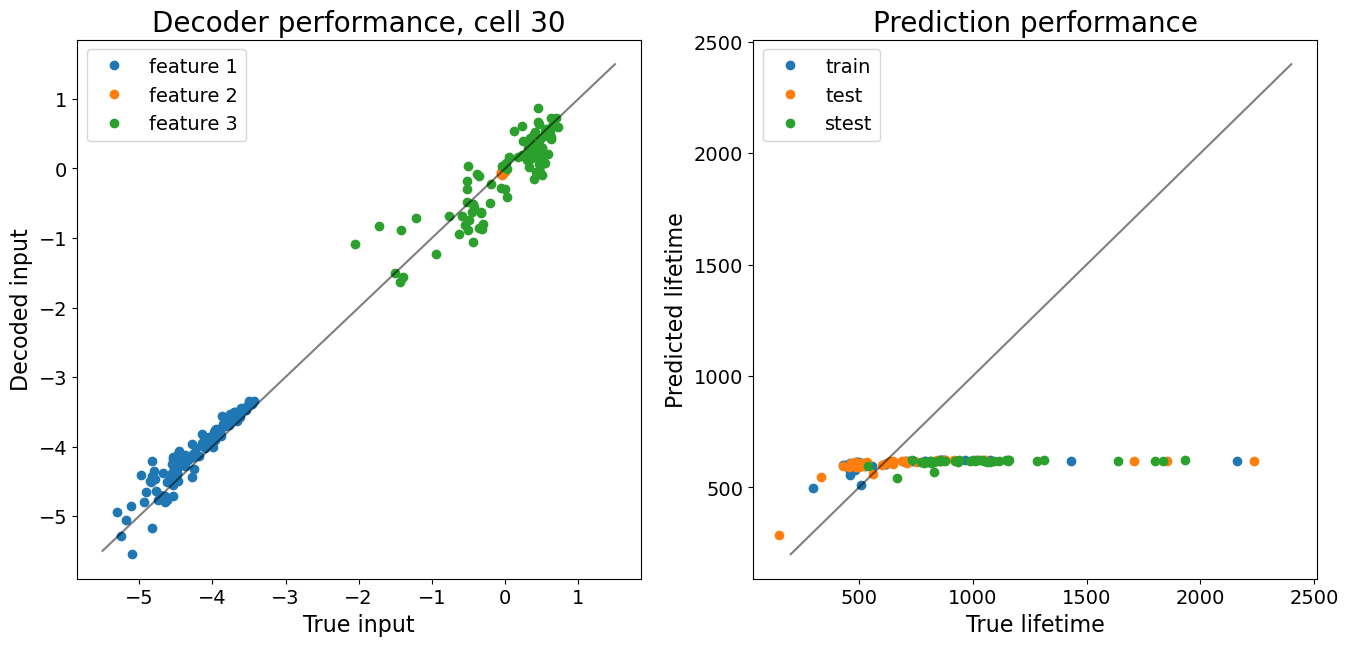

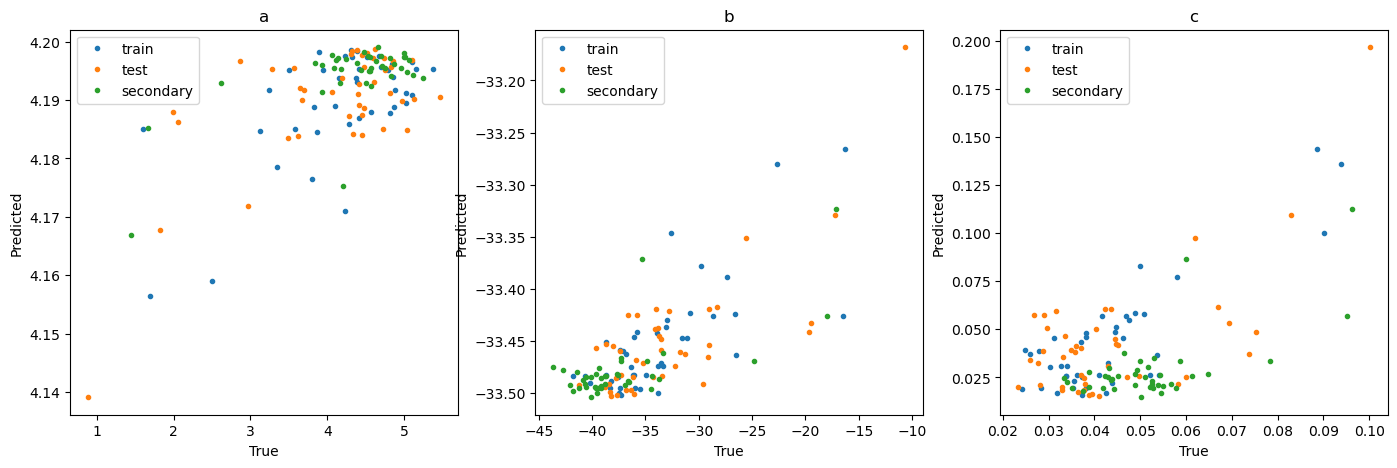

Stage 1:

Epoch 2500/25000,   	decoding loss: 0.18,    	prediction loss: 85884.72,  	reg_loss: 5.75
Epoch 5000/25000,   	decoding loss: 0.62,    	prediction loss: 80421.29,  	reg_loss: 5.69
Epoch 7500/25000,   	decoding loss: 0.51,    	prediction loss: 76234.31,  	reg_loss: 5.59
Epoch 10000/25000,   	decoding loss: 0.55,    	prediction loss: 68294.54,  	reg_loss: 5.50
Epoch 12500/25000,   	decoding loss: 0.59,    	prediction loss: 59748.05,  	reg_loss: 5.41
Epoch 15000/25000,   	decoding loss: 0.68,    	prediction loss: 50869.27,  	reg_loss: 5.31
Epoch 17500/25000,   	decoding loss: 0.78,    	prediction loss: 41148.88,  	reg_loss: 5.22
Epoch 20000/25000,   	decoding loss: 0.82,    	prediction loss: 32837.55,  	reg_loss: 5.13
Epoch 22500/25000,   	decoding loss: 1.08,    	prediction loss: 25454.95,  	reg_loss: 5.04
Epoch 25000/25000,   	decoding loss: 1.42,    	prediction loss: 18997.63,  	reg_loss: 4.97

Cycle life prediction errors:

train 	 137.82
test 	 nan
sec 	 nan


/tmp/ipykernel_250825/3449252126.py:158: RuntimeWarning: invalid value encountered in power
  predicted_cycle_life = np.power(np.exp(-A)*(0.2-C), 1.0/B)
/tmp/ipykernel_250825/3449252126.py:189: RuntimeWarning: invalid value encountered in power
  predicted_cycle_lives = np.power(np.exp(-A)*(0.2-C),1/B)


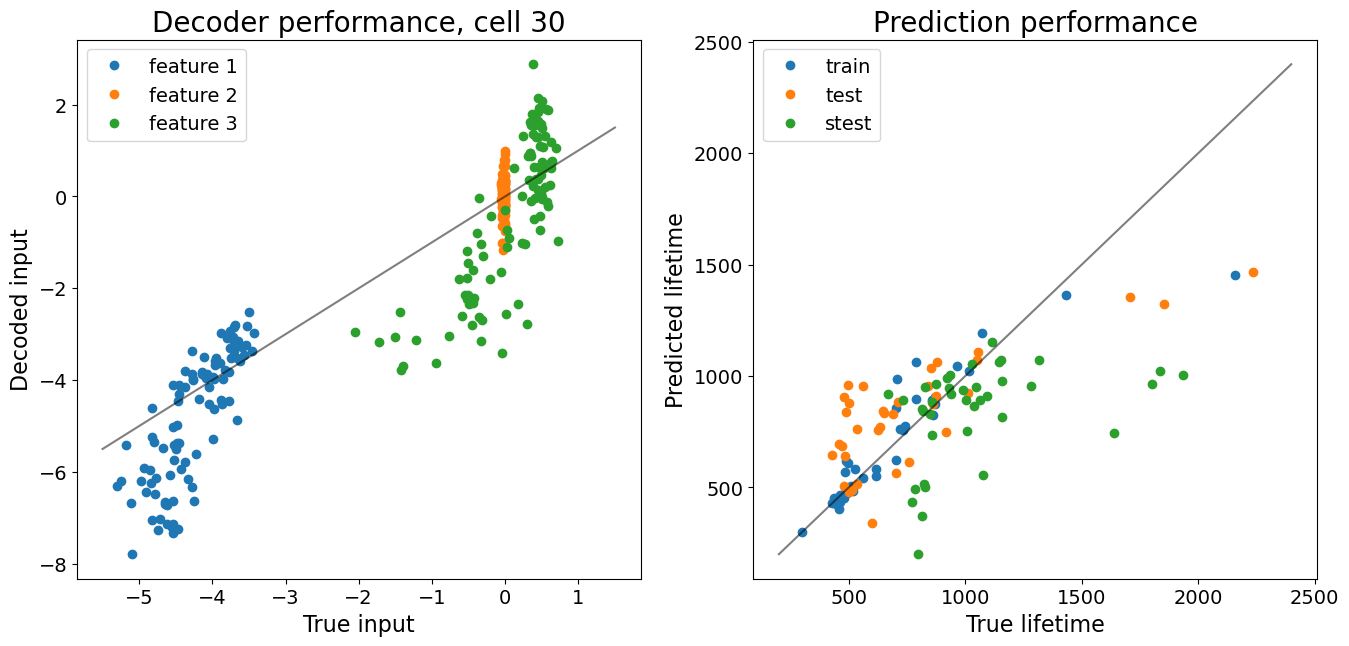

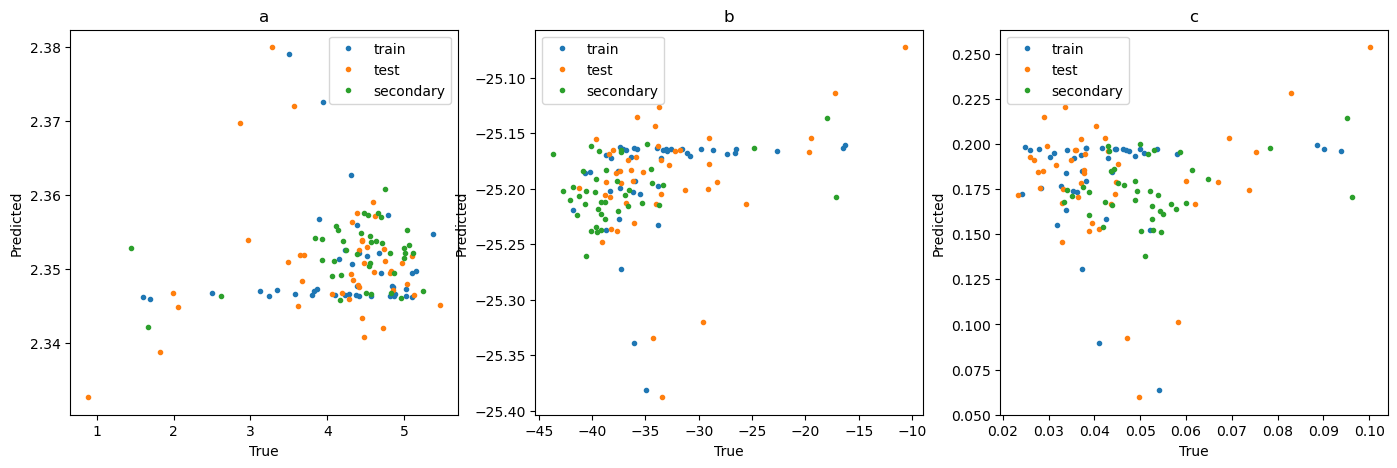

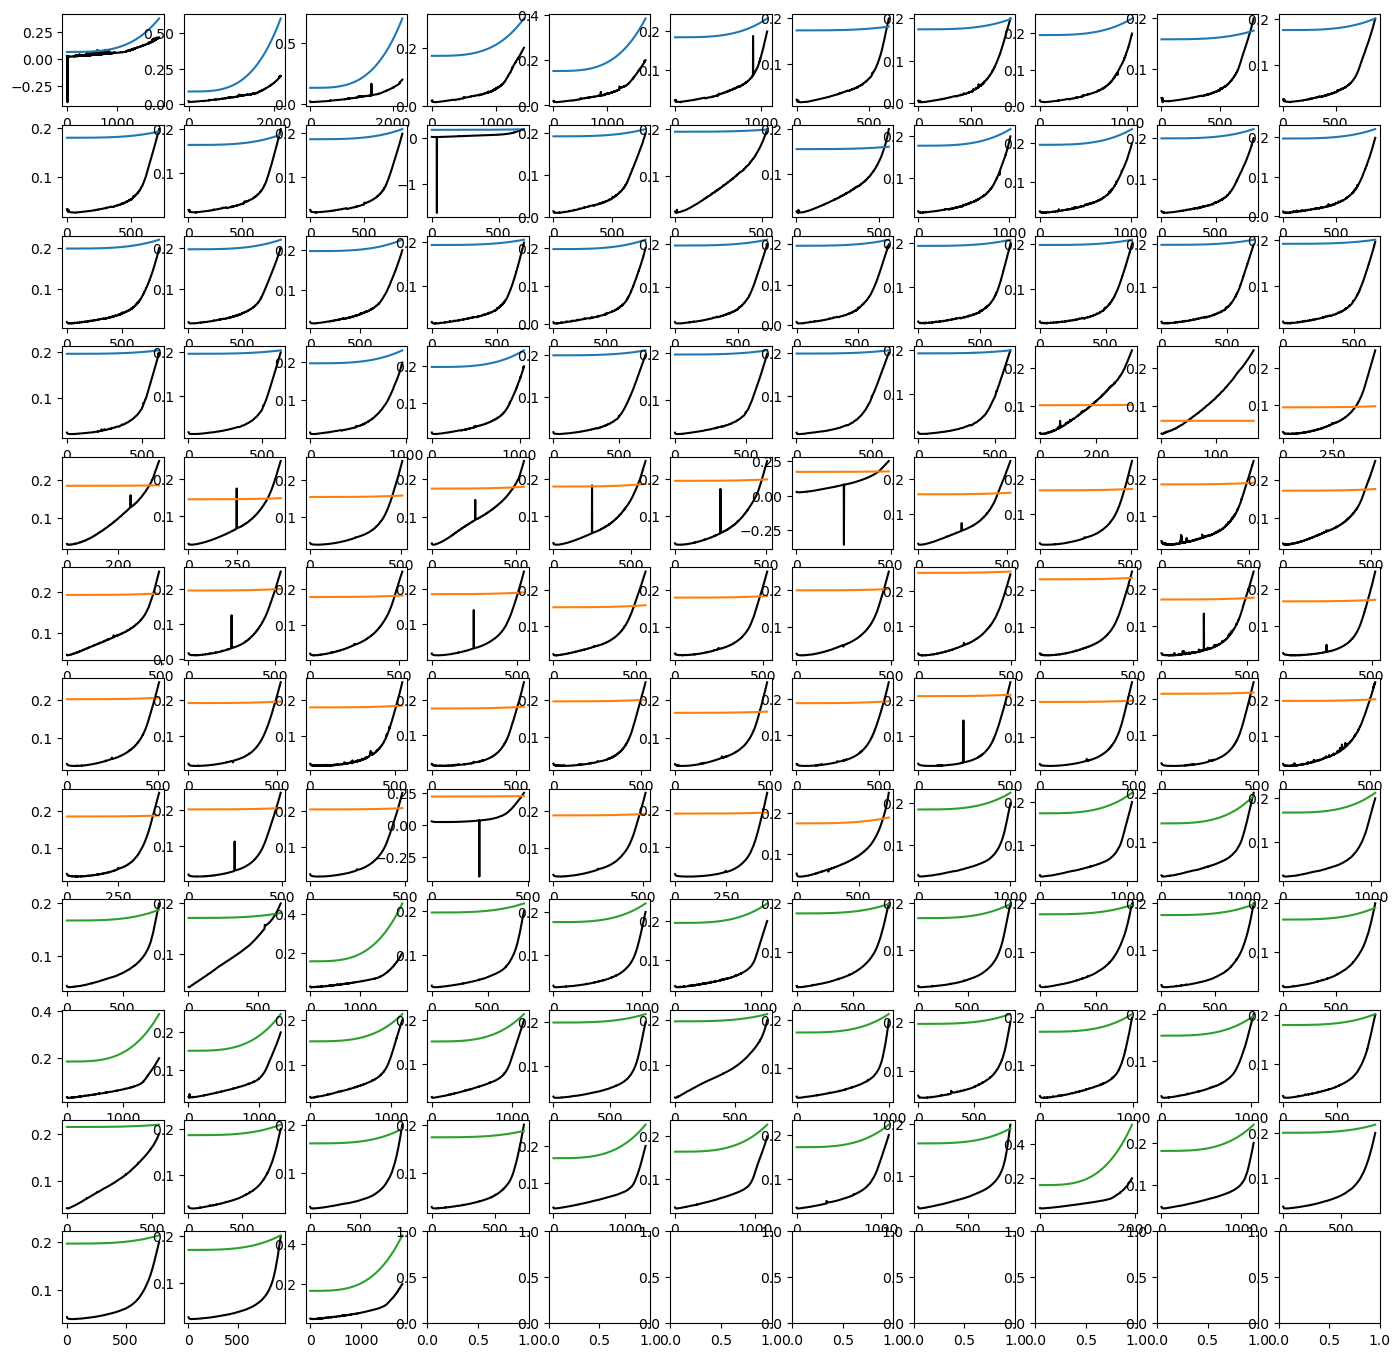

In [182]:
train_policy = {
    "num_stages": 1,
    "epochs": [800, 1000],
    "learning_rates": [5e-3, 2e-4],
    "batch_sizes": [64, 64],
    "prediction_weights": [1, 1],
    "decoding_weights": [0.1, 0.1],
    "en_weights": [1, 1]
}


model = AutoEncoder_Model(n_features=len(features), n_cycles=n_cycles, d_model=1)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit_1(train, test, stest, train_policy, curve_plots=False)

train_policy = {
    "num_stages": 1,
    "epochs": [25000, 10000],
    "learning_rates": [1.3e-6, 1e-7],
    "batch_sizes": [64, 64],
    "prediction_weights": [1, 1],
    "decoding_weights": [0, 0],
    "en_weights": [1, 1]
}
model.fit_2(train, test, stest, train_policy, curve_plots=True)